In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


bd = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "sujal170811",
                            database = "ecommerce")

cur = bd.cursor()

### 1. List all unique cities where customers are located.

In [45]:
query = """ SELECT DISTINCT customer_city FROM customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Cities'])
df.head()

,Cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### 2. Count the number of orders placed in 2017.

In [9]:
query = """ SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are", data[0][0]

('Total orders placed in 2017 are', 135303)

### 3. Find the total sales per categories.

In [10]:
query = """ SELECT UPPER(products.product_category) category,
ROUND(SUM(payments.payment_value),2) sales
FROM products JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments
ON payments.order_id = order_items.order_id
GROUP BY category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category', 'Sales'])
df

,Category,Sales
0,PERFUMERY,6080863.92
1,FURNITURE DECORATION,17162116.70
2,TELEPHONY,5842584.61
3,BED TABLE BATH,20550644.05
4,AUTOMOTIVE,10227531.97
...,...,...
69,CDS MUSIC DVDS,14393.16
70,LA CUISINE,34962.36
71,FASHION CHILDREN'S CLOTHING,9428.04
72,PC GAMER,26093.16


### 4. Calculate the percentage of orders that were paid in installments.

In [12]:
query = """ SELECT (SUM(CASE WHEN payment_installments >= 1 THEN 1
ELSE 0 END)) / COUNT(*)*100 FROM payments"""

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments is", data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

### 5. Count the number of customers from each state.

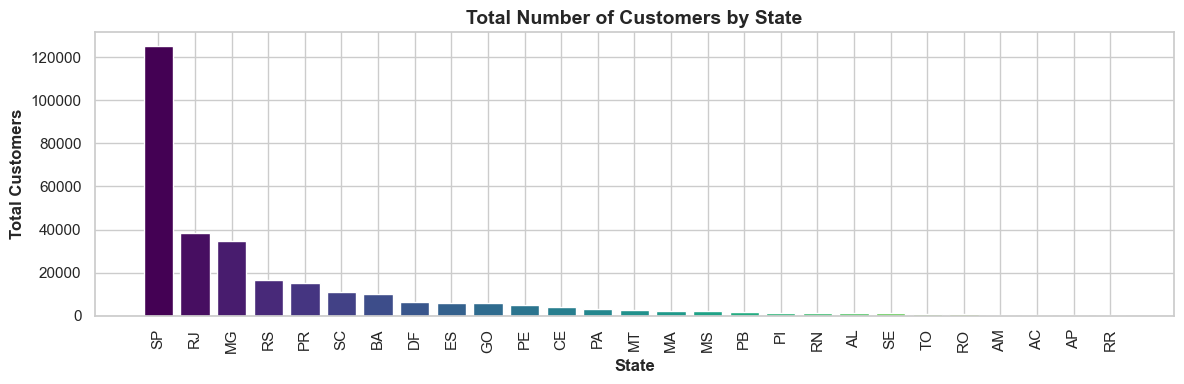

In [54]:
query = """ SELECT customer_state, COUNT(customer_id)
FROM customers 
GROUP BY customer_state
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["State", "Total_Customers"])
df = df.sort_values(by = "Total_Customers", ascending = False)

colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(df["State"])))
plt.figure(figsize=(12, 4))
bars = plt.bar(df["State"], df["Total_Customers"], color=colors)
plt.xlabel("State", fontsize=12, fontweight='bold')
plt.ylabel("Total Customers", fontsize=12, fontweight='bold')
plt.title("Total Number of Customers by State", fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 6. Calculate the number of orders per month in 2018.

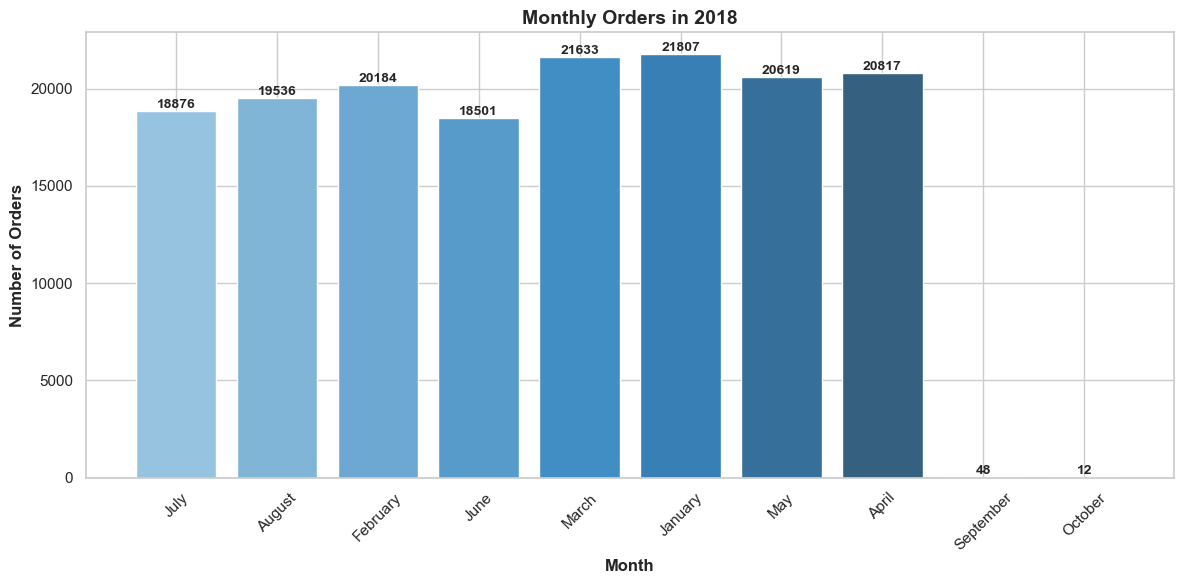

In [53]:
query = """ SELECT MONTHNAME(order_purchase_timestamp) months, COUNT(order_id)
FROM orders WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY months
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Months', 'Orders'])
o = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October"]

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
colors = sns.color_palette("Blues_d", len(df)) 

bars = plt.bar(df['Months'], df['Orders'], color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.xlabel("Month", fontsize=12, fontweight='bold')
plt.ylabel("Number of Orders", fontsize=12, fontweight='bold')
plt.title("Monthly Orders in 2018", fontsize=14, fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 7. Find the average number of products per order, grouped by customer city.

In [58]:
query = """ WITH count_per_order AS
(SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
FROM orders JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc),2) average_orders
FROM customers JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY average_orders DESC;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Cities', 'Avg_orders'])
df.head(10)

,Cities,Avg_orders
0,padre carvalho,42.00
1,celso ramos,39.00
2,datas,36.00
3,candido godoi,36.00
4,matias olimpio,30.00
5,cidelandia,24.00
6,curralinho,24.00
7,picarra,24.00
8,morro de sao paulo,24.00
9,teixeira soares,24.00


### 8. Calculate the percentage of total revenue contributed by each product category.

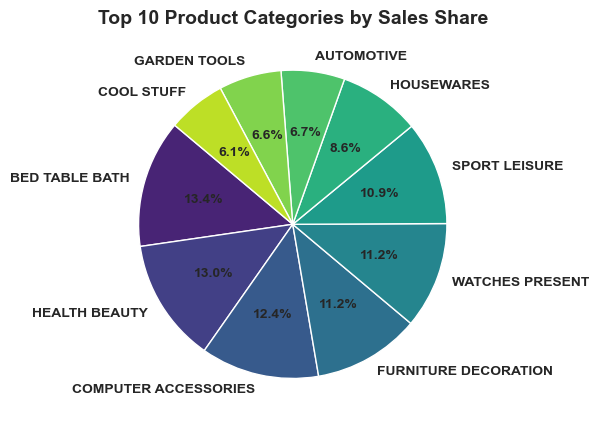

In [72]:
query = """ SELECT UPPER(products.product_category) category,
ROUND((SUM(payments.payment_value)/(SELECT SUM(payment_value) FROM payments))*100,2) sales
FROM products JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments
ON payments.order_id = order_items.order_id
GROUP BY category 
ORDER BY sales DESC
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category', 'Percentage_Distribution'])
df_top = df.head(10)

plt.figure(figsize=(6, 6))
colors = plt.get_cmap("viridis")(np.linspace(0.1, 0.9, len(df_top)))

plt.pie(
    df_top["Percentage_Distribution"],
    labels=df_top["Category"],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)

plt.title("Top 10 Product Categories by Sales Share", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 9. Identify the correlation between product price and the number of timer a product has been purchased.

In [75]:
 query = """SELECT products.product_category,
COUNT(order_items.product_id),
ROUND(AVG(order_items.price), 2)
FROM products JOIN order_items
ON products.product_id = order_items.product_id
GROUP BY products.product_category;
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category', 'Order_Count', 'Price'])

arr1 = df['Order_Count']
arr2 = df['Price']

a = np.corrcoef(arr1, arr2)
print("The correlation between price and number of times a product has been purchased is", a[0][1])

The correlation between price and number of times a product has been purchased is -0.10631514167157563


### 10. Calculate the total revenue generated by each seller, and rank them by revenue.

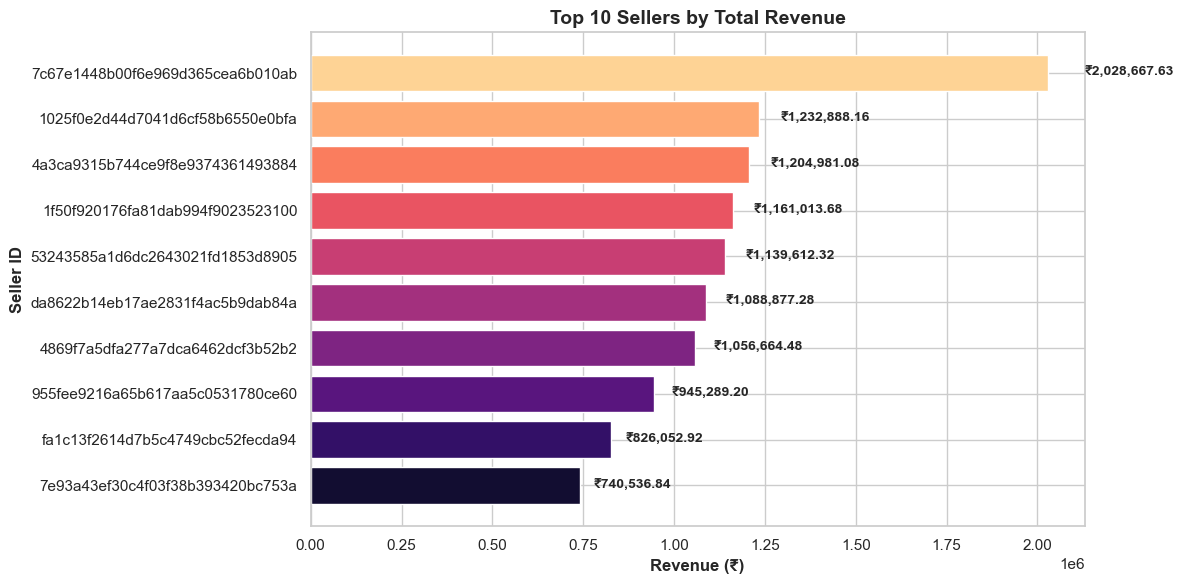

In [79]:
query = """ SELECT *, DENSE_RANK() OVER(ORDER BY revenue DESC) AS rn FROM
(SELECT order_items.seller_id, SUM(payments.payment_value) revenue
FROM order_items JOIN payments
ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id) AS a
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Seller_ID', 'Revenue', 'Rank'])

df_top = df.sort_values(by='Revenue', ascending=False).head(10)

df_top = df_top.sort_values(by='Revenue', ascending=True)

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
colors = sns.color_palette("magma", len(df_top))
bars = plt.barh(df_top['Seller_ID'], df_top['Revenue'], color=colors)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.05 * width, bar.get_y() + bar.get_height()/2,
             f'₹{width:,.2f}', va='center', fontsize=10, fontweight='bold')

plt.xlabel("Revenue (₹)", fontsize=12, fontweight='bold')
plt.ylabel("Seller ID", fontsize=12, fontweight='bold')
plt.title("Top 10 Sellers by Total Revenue", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 11. Calculate the moving average of order values for each customer over their order history.

In [84]:
query = """ SELECT customer_id, order_purchase_timestamp, payment,
AVG(payment) OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
FROM 
(SELECT orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
FROM payments JOIN orders
ON payments.order_id = orders.order_id) AS a
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Customer_ID', 'Timestamp', 'Payments', 'Moving_Avg'])
df.head(10)

,Customer_ID,Timestamp,Payments,Moving_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
5,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
6,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
7,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
8,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
9,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004


### 12. Calculate the cumulative sales per month for each year.

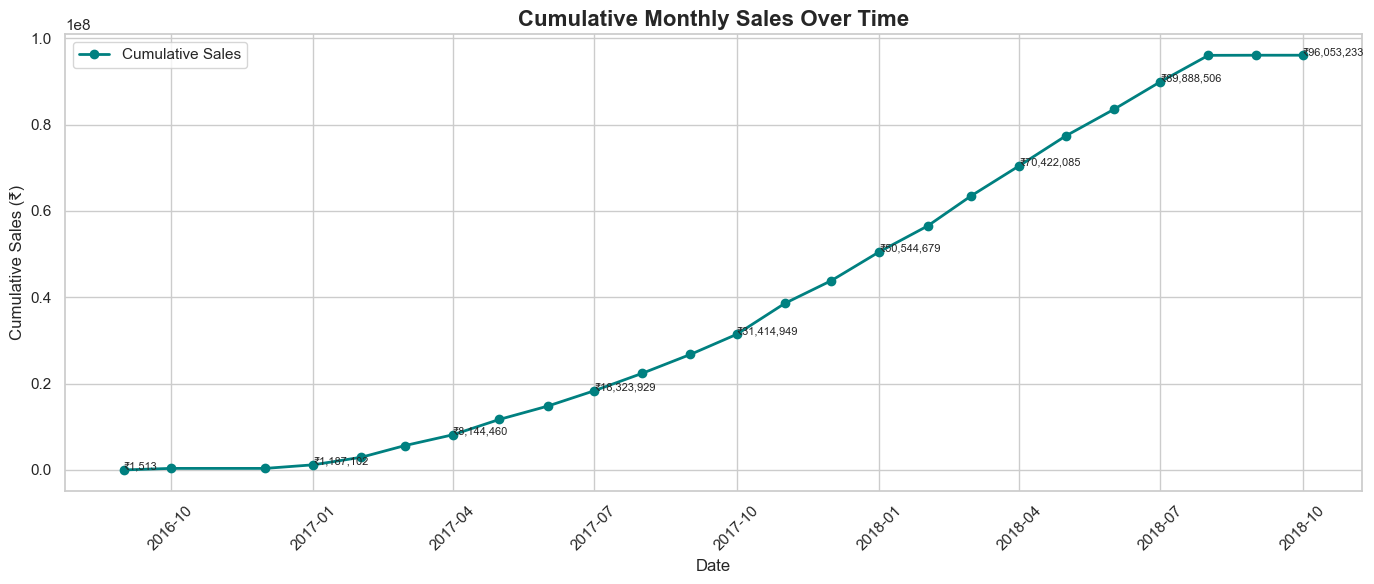

In [87]:
query = """ SELECT years, months, payment, SUM(payment)
OVER(ORDER BY years, months) Cumulative_sales 
FROM
(SELECT YEAR(orders.order_purchase_timestamp) AS years,
MONTH(orders.order_purchase_timestamp) AS months,
ROUND(SUM(payments.payment_value), 2) AS payment
FROM orders JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years, months 
ORDER BY years, months) AS a
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Year', 'Month', 'Monthly_Sales', 'Cumulative_Sales'])

df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

df = df.sort_values(by='Date')

sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

plt.plot(df['Date'], df['Cumulative_Sales'], marker='o', linestyle='-', linewidth=2, color='teal', label='Cumulative Sales')

for i, value in enumerate(df['Cumulative_Sales']):
    if i % 3 == 0:  # annotate every 3rd point to reduce clutter
        plt.text(df['Date'].iloc[i], value + 10000, f"₹{value:,.0f}", fontsize=8)

plt.title("Cumulative Monthly Sales Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Sales (₹)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 13. Calculate the year-over-year growth rate of total sales.

In [95]:
query = """ WITH yearly_sales AS (
    SELECT 
        YEAR(o.order_purchase_timestamp) AS year,
        ROUND(SUM(p.payment_value), 2) AS total_revenue
    FROM orders o
    JOIN payments p ON o.order_id = p.order_id
    GROUP BY YEAR(o.order_purchase_timestamp)
    ORDER BY year
)

SELECT 
    year,
    total_revenue,
    ROUND(
        (total_revenue - LAG(total_revenue) OVER(ORDER BY year)) 
        / LAG(total_revenue) OVER(ORDER BY year) * 100, 2
    ) AS yoy_growth_percentage
FROM yearly_sales;
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Year', 'Total_Revenue', 'YoY_Growth'])
df

,Year,Total_Revenue,YoY_Growth
0,2016,356174.04,NaN
1,2017,43498480.37,12112.7
2,2018,52198578.31,20.0


### 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [97]:
query = """ WITH 
a AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b AS (
    SELECT a.customer_id, 
           COUNT(DISTINCT orders.order_purchase_timestamp) AS repeat_orders
    FROM a 
    JOIN orders ON orders.customer_id = a.customer_id
               AND orders.order_purchase_timestamp > a.first_order
               AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)

SELECT 
    100 * (COUNT(DISTINCT b.customer_id) / COUNT(DISTINCT a.customer_id)) AS repeat_rate_percentage
FROM a 
LEFT JOIN b ON a.customer_id = b.customer_id;

"""
cur.execute(query)

data = cur.fetchall()

data

# Why is the output NULL?
# This query is attempting to calculate the percentage of new customers (those with a first order) who returned to place another order within 6 months.
# However, it returns NULL because the denominator — COUNT(DISTINCT b.customer_id) — becomes zero, which leads to a division by zero.
# This happens when no customers placed a second order within 6 months of their first order, based on the available data.

[(Decimal('0.0000'),)]

### 15. Identify the top 3 customers who spent the most money in each year.

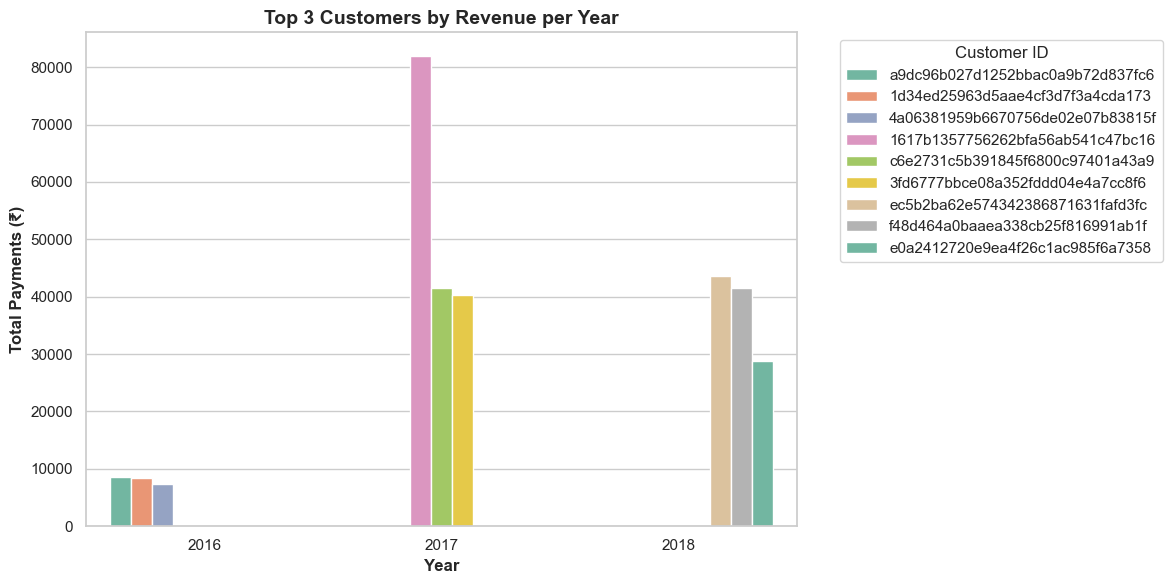

In [102]:
query = """ SELECT years, customer_id, payment, d_rank
FROM
(SELECT YEAR(orders.order_purchase_timestamp) years,
orders.customer_id,
SUM(payments.payment_value) payment,
DENSE_RANK() 
OVER(PARTITION BY YEAR(orders.order_purchase_timestamp)
ORDER BY SUM(payments.payment_value)DESC) d_rank
FROM orders JOIN payments
ON payments.order_id = orders.order_id
GROUP BY YEAR(orders.order_purchase_timestamp), orders.customer_id) AS a

WHERE d_rank <= 3

"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Year', 'Customer_ID', 'Total_Payment', 'Rank'])

df['Year'] = df['Year'].astype(str)  # for proper categorical sorting

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.barplot(data=df, x='Year', y='Total_Payment', hue='Customer_ID', palette='Set2')

plt.title("Top 3 Customers by Revenue per Year", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12, fontweight='bold')
plt.ylabel("Total Payments (₹)", fontsize=12, fontweight='bold')
plt.legend(title='Customer ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()